# Lidarデータの処理(pdal pilepine 編)
---
このNotebookでは`pdal`をpythonで扱う`pipeline`処理に焦点を当てています。

PDAL（Point Data Abstraction Library）は、点群データの変換と操作に用いられるC++ライブラリです。PDALはCLIで操作する事もできますが、python内で操作する事も可能です。

このNotebookでは`OpenNagasaki`からダウンロード可能な`.las`フォーマットのデータを題材に pdal の基本的な使い方を学習していきます。

 - [PDAL Document](https://pdal.io/en/2.7-maintenance/)

 - [PDAL Python](https://pdal.io/en/2.7-maintenance/python.html)
 
 - [PDAL Filters](https://pdal.io/en/2.7-maintenance/stages/filters.expression.html#filters-expression)

 - [PDAL Pipeline](https://pdal.io/en/2.7-maintenance/pipeline.html)

 - [PDAL Pipeline example](https://github.com/PDAL/PDAL/tree/master/test/data/pipeline)

 - [オープンナガサキ](https://opennagasaki.nerc.or.jp/)


## Import modules.

In [109]:
import json
from pprint import pprint

import geopandas as gpd
import open3d
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pdal
import rasterio
import seaborn
import shapely
plt.style.use('ggplot')

FILE_PATH = "../datasets/01ID7913_org.las"
IN_EPSG = 'EPSG:6669'

## データの概要を確認する。
---
データを処理するPipelineを作成する前にデータの中身を見てみましょう。中身を確認しない事には、どの様な処理が必要かを決める事が出来ません。

事前に`.json`ファイルにPipelineの処理を書いておいても構いませんが、せっかくpythonを使用するので、辞書型のオブジェクトに処理を記述して動作させてみましょう。

In [2]:
# `reader.las`ではなく`readers.las`なので注意
sentence = \
    {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": FILE_PATH
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()
metadata = pipeline.metadata
pprint(metadata)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': '',
                              'compressed': False,
                              'copc': False,
                              'count': 6684582,
                              'creation_doy': 0,
                              'creation_year': 0,
                              'dataformat_id': 2,
                              'dataoffset': 227,
                              'filesource_id': 0,
                              'global_encoding': 0,
                              'global_encoding_base64': 'AAA=',
                              'header_size': 227,
                              'major_version': 1,
                              'maxx': -3000,
                              'maxy': 38250,
                              'maxz': 1302.339999,
                              'minor_version': 2,
                              'minx': -4000,
                              'miny': 37500,
                 

上記でprintしたデータの中の`spatialreference`には空の文字列が入力されています。`Spatial Reference(srs: Spatial Reference System)`とは空間参照系の事です。geopandasなんかでは`crs(Coordinate Reference System: 座標参照系)`という表記になっていたりします。

空間参照系とは現実世界の位置を特定する為のルールの事であり、空間参照系の種類によって原点となる場所が異なります。今回使用するデータの座標参照系は、オープンナガサキのサイトに書いてあるJGD2011の1系(EPSG:6669)であり、原点は長崎県の海にあります。

空間参照系を定義する前に、まずこのデータの示す範囲を地図で見てみましょう。


In [3]:
meta_data_readers = metadata.get('metadata').get('readers.las')
max_x = meta_data_readers.get('maxx')
max_y = meta_data_readers.get('maxy')
min_x = meta_data_readers.get('minx')
min_y = meta_data_readers.get('miny')
boundary = shapely.box(*[max_x, max_y, min_x, min_y])

# geopandasを使用し動的なMapに投影してみましょう。実際にダウンロードした場所と同じ範囲が表示されるはずです。
gdf = gpd.GeoDataFrame(geometry=[boundary], crs=IN_EPSG)
# gdf.explore()

## 座標参照系を定義する
---
データに座標参照系を定義する場合は、Pipeline処理の`readers.xxx`でデータを読み込む際に`default_srs`を指定して読み込む事で定義できます。

 - [オープンナガサキのデータの座標参照系が書いてあります。](https://opennagasaki.nerc.or.jp/terms.html?20240228)
 - [PDAL readers]

In [4]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': FILE_PATH,
                'default_srs': IN_EPSG
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()
pprint(pipeline.metadata)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': 'PROJCS["JGD2011 / '
                                                       'Japan Plane '
                                                       'Rectangular CS '
                                                       'I",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS '
                                                       '1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",33],PARAMETER["central_meridian",129.5],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","6669"]]',
                              'compress

## データのビジュアライズ
----

### 座標データの用意
pipelineから`numpy.ndarray`のオブジェクトを取り出す事が出来ます。

In [5]:
arys = pipeline.arrays
arys

[array([(-3999.7200002 , 37554.73      , 249.50999987, 121, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12593, 20303, 22616),
        (-3966.03000069, 37517.36999991, 253.99999994, 122, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12079, 17733, 19018),
        (-3972.01000013, 37543.96999932, 253.37999986,  95, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 16448, 21588, 21074),
        ...,
        (-3000.        , 37897.95999958, 323.77999955,  92, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 65535, 65535, 65535),
        (-3000.16000075, 37897.93999931, 323.77999955, 167, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 22102, 26471, 24158),
        (-3000.16000075, 37912.35999957, 317.51999955,  24, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12850, 21331, 22873)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 

配列には列名が設定されているようなので、`pandas.DataFrame`にしてしまいましょう。

設定したら`pandas.DataFrame.describe`メソッドで記述統計量を確認します。

In [6]:
df = pd.DataFrame(arys[0])
df.describe()
"""
実行してみると、座標の他には反射強度と色情報位しか情報が無い事が分かります。
"""

'\n実行してみると、座標の他には反射強度と色情報位しか情報が無い事が分かります。\n'

DataFrameからXYZの情報を取り出し`open3d`で点群を可視化してみましょう。

In [7]:
xyz_names = ['X', 'Y', 'Z']

point_cloud = df[xyz_names].to_numpy()
print(point_cloud.shape)
point_cloud

(6684582, 3)


array([[-3999.7200002 , 37554.73      ,   249.50999987],
       [-3966.03000069, 37517.36999991,   253.99999994],
       [-3972.01000013, 37543.96999932,   253.37999986],
       ...,
       [-3000.        , 37897.95999958,   323.77999955],
       [-3000.16000075, 37897.93999931,   323.77999955],
       [-3000.16000075, 37912.35999957,   317.51999955]])

In [8]:
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
open3d.visualization.draw_geometries([visualize])

上記を実行するとわかるのですが、このデータにはゴミ（外れ値）が混ざっている事が確認できます。次はこのゴミを取り除きましょう。

### 条件式を使用した外れ値の除去
z値にどうやらおかしな値が紛れ込んでいるようです。点群を可視化して確認すると全体の高さはそこまででもない様なので、800m以上あるデータは取り除いてしまいましょう。

pipelineでは`filters.expression`を使用し、条件式を適用させる事が出来ます。

 - [Filters.expression](https://pdal.io/en/2.7-maintenance/stages/filters.expression.html#filters-expression)

In [9]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': FILE_PATH,
                'default_srs': IN_EPSG
            },
            {
                "type":"filters.expression",
                "expression":"(Z < 800)"
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

df = pd.DataFrame(pipeline.arrays[0])
print(f"max z: {df['Z'].max()}")

max z: 519.6199996727147


もう一度可視化して確認してみます。

In [17]:
point_cloud = df[xyz_names].to_numpy()
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
open3d.visualization.draw_geometries([visualize])

外れ値が除去されて見やすくなったと思います。

### データの色付け

せっかく色情報が入力されているので、点群に色を付けて可視化してみましょう。しかしDataFrameを見てもわかる通り、8bitのデータではないようです。

ヒストグラムで色の範囲を確認してみましょう。

Red max: 0.9999847412109375


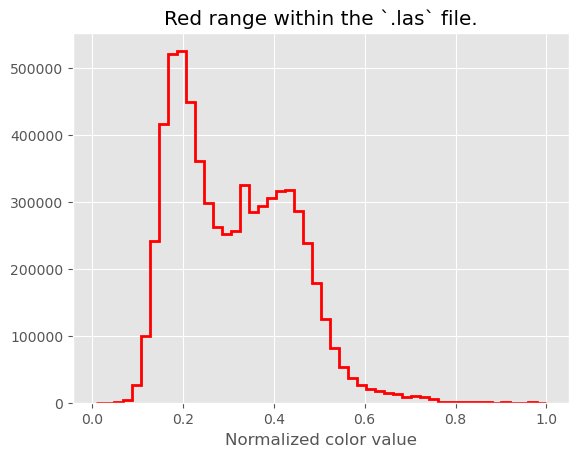

In [29]:
print(f"Red max: {df['Red'].max()}")
plt.hist(df['Red'], bins=50, histtype='step', lw=2, color='red')
plt.title('Red range within the `.las` file.')
plt.xlabel('Normalized color value');

ヒストグラムを見ると、色の範囲は65535までの様です。つまり16bitで表された色だという事が分かります。

今回は上記を8bitの値に変換する必要はなく、単純に16bitの最大値を1に、最小値を0にスケーリングします。

In [14]:
color_names = ['Red', 'Green', 'Blue']

df[color_names] = df[color_names] / 2**16

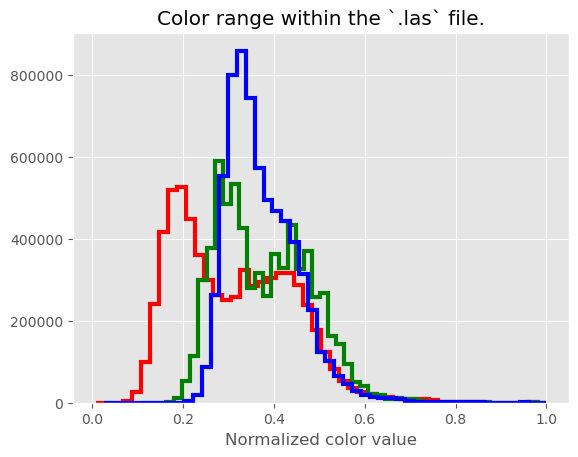

In [26]:
fig, ax = plt.subplots()
for color_name in color_names:
    ax.hist(
        df[color_name], bins=50, 
        histtype='step', lw=3, edgecolor=color_name
    )
ax.set_title('Color range within the `.las` file.')
ax.set_xlabel('Normalized color value');

In [30]:
point_cloud = df[xyz_names].to_numpy()
colors = df[color_names].to_numpy()
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
visualize.colors = open3d.utility.Vector3dVector(colors)
open3d.visualization.draw_geometries([visualize])

綺麗に色がついていたと思います。ただ処理内容を確認するのにわざわざ色を付ける必要があるかは別ですが...


## DTMの作成
---
上空から地上を測ったデータでは地形の高さのデータや表層の高さのデータを使用したい場合が多くあります。
次は`DTM(Digital Terrein Model : 数値地形モデル)`をPipeline処理で作成します。

地形の高さを求める為には、地形とそれ以外とで点群を分類する必要があります。pdalには地形データを取得するいくつかのモジュールが用意されています。

 - [filters.csf (Cloth Simulation Filter)] (https://pdal.io/en/2.7-maintenance/stages/filters.csf.html#filters-csf)
 
pipelineの処理内容としては
 
 1. readers.las -> データの読み込みと座標参照系の定義

 2. filters.expression -> 外れ値の除去

 3. filters.smrf -> 地上点とそれ以外への点群分類とクラス番号の付与

 

In [120]:
OUT_FILE = r'../datasets/dtm.tif'

sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': FILE_PATH,
                'default_srs': IN_EPSG
            },
            {
                "type":"filters.expression",
                "expression":"(Z <= 800)"
            },
            {
                "type":"filters.smrf",
                "scalar":1.2,
                "slope":0.5,
                "window":20.0
            }
        ]
    }

# {
#     'type': 'writers.gdal',
#     'filename': OUT_FILE,
#     'output_type': 'min',
#     'gdaldriver': 'GTiff',
#     'window_size': 3,
#     'resolution': 1.0
# }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

6684581

### 断面図を確認してどの様に分類されているかを確認してみる


In [121]:
arys = pipeline.arrays
df = pd.DataFrame(arys[0])
geoms = gpd.points_from_xy(df['X'], df['Y'], df['Z'])
gdf = gpd.GeoDataFrame(df, geometry=geoms, crs=IN_EPSG)

print(f"shape: {gdf.shape}")
print(f"class: {gdf['Classification'].unique()}")
gdf.head()

shape: (6684581, 20)
class: [1 2]


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,Red,Green,Blue,geometry
0,-3999.720000,37554.730000,249.51,121,0,0,0,0,1,0,0,0,0,0.0,0,29,12593,20303,22616,POINT Z (-3999.720 37554.730 249.510)
1,-3966.030001,37517.370000,254.00,122,0,0,0,0,2,0,0,0,0,0.0,0,29,12079,17733,19018,POINT Z (-3966.030 37517.370 254.000)
2,-3972.010000,37543.969999,253.38,95,0,0,0,0,1,0,0,0,0,0.0,0,29,16448,21588,21074,POINT Z (-3972.010 37543.970 253.380)
3,-3915.060000,37607.260000,253.09,193,0,0,0,0,1,0,0,0,0,0.0,0,29,11051,16705,19018,POINT Z (-3915.060 37607.260 253.090)
4,-3938.120001,37593.970000,252.35,222,0,0,0,0,1,0,0,0,0,0.0,0,29,11822,21074,20817,POINT Z (-3938.120 37593.970 252.350)


In [126]:
center_y = max_y - min_y + min_y - 20
holizontal_line = \
    shapely.LineString([(min_x, center_y), (min_x + 50, center_y)])
sample_area = holizontal_line.buffer(0.5, cap_style='flat')
gdf_sample = gdf[gdf.intersects(sample_area)].copy()

<Axes: xlabel='X', ylabel='Z'>

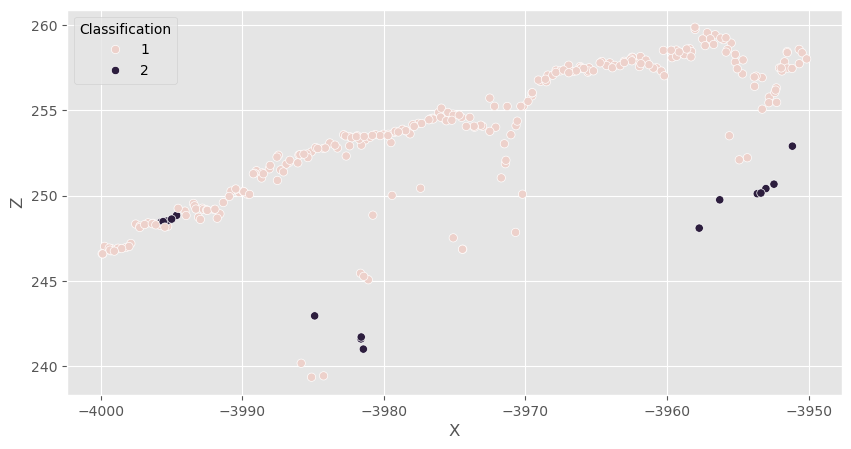

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))
seaborn.scatterplot(data=gdf_sample, x="X", y="Z", hue="Classification")

DTMを画像として出力したら、`rasterio`で読み込んでビジュアライズしてみましょう。

In [75]:
ds = rasterio.open(OUT_FILE)
dtm_ary = ds.read(1)

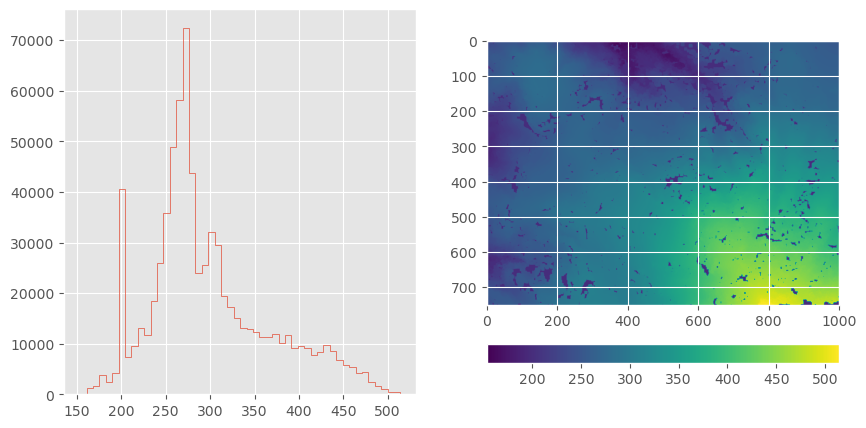

In [84]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

_dtm_ary = np.where(dtm_ary <= 0, 200, dtm_ary)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].hist(_dtm_ary.flatten(), bins=50, histtype='step')
im = ax[1].imshow(_dtm_ary)
ax_divider = make_axes_locatable(ax[1])
cax = ax_divider.append_axes("bottom", size="7%", pad="15%")
cb2 = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("bottom")

畳み込みで値を補完したい。